In [4]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from io import StringIO
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [5]:
fetcher = DataFetcher(DB_PARAMS)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:132: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:107: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
df_q = fetcher.fetch_data(
    regressors=[
        'stretch_default',
        'eps_surprise',
        'f_size',
        'doc_len'
        ],
    report_filters={'report_type' : ['10-Q']},
       prepare_fixed_effects=True,
    )

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:164: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Expanding list regressor 'stretch_default' into 107 columns...


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:211: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:226: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  companies_df = pd.read_sql_query(query, conn)


In [7]:
df_q.isna().sum()

report_type          0
eps_surprise        63
f_size               0
doc_len              0
segment_1            0
                  ... 
four_day_r_vol     210
five_day_r_vol     210
six_day_r_vol      210
seven_day_r_vol    210
full_q_r_vol       528
Length: 139, dtype: int64

In [ ]:
class FEModeler:
    def __init__(self, df: pd.DataFrame,):
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}

    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        model = PanelOLS.from_formula(formula, data=data, check_rank=False)
        result = model.fit(cov_type='kernel')
        return result.summary
    
    @staticmethod
    def try_convert_numeric(col):
        try:
            return pd.to_numeric(col)
        except Exception:
            return col

    def compute_adaptive_lasso(self, additional_regs: list[str] = None):
        """
        Run adaptive Lasso for each (target, timeframe) and store non-zero coefficients.
        
        Args:
            additional_regs: List of additional regressor names to include (e.g., ['f_size', 'eps_surprise'])
        """
        self.lasso_coefs = {}
    
        targets = ['returns', 'e_returns', 'abn_returns', "r_vol"]
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter']
        var_names = self.df.columns
        base_regs = var_names[4:111]
        all_additional = additional_regs if additional_regs else []
    
        for target in targets:
            self.lasso_coefs[target] = {}
    
            for frame in time_frames:
                y_col = 111 + targets.index(target) * 7 + time_frames.index(frame)
                y_name = var_names[y_col]
    
                cols = list(base_regs) + all_additional + [y_name]
                data = self.df[cols].dropna().apply(self.try_convert_numeric)
    
                X = data[list(base_regs) + all_additional].values
                y = data[y_name].values
    
                # Adaptive weights based on OLS (ridge-stabilized in case of multicollinearity)
                ols_coef = np.linalg.pinv(X) @ y
                weights = 1 / (np.abs(ols_coef) + 1e-6)
    
                X_weighted = X / weights
    
                model = LassoCV(cv=5, max_iter=10000).fit(X_weighted, y)
                coefs_raw = model.coef_ / weights  
    
                names = list(base_regs) + all_additional
                coefs_dict = {
                    name: coef for name, coef in zip(names, coefs_raw)
                    if abs(coef) > 1e-6
                }
    
                self.lasso_coefs[target][frame] = coefs_dict
        return self.lasso_coefs

    def plot_adaptive_lasso(self):
        """
        Plot bar charts of adaptive Lasso non-zero coefficients for each (target, timeframe) combination.
        """
        for target, frame_dict in self.lasso_coefs.items():
            for frame, coef_dict in frame_dict.items():
                if not coef_dict:
                    continue

                names, coefs = zip(*coef_dict.items())
                x = np.arange(len(names))

                plt.figure(figsize=(12, 5))
                plt.bar(x, coefs, color='tab:purple', width=0.6)
                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, names, rotation=90, fontsize=8)
                plt.title(f'Adaptive Lasso Coefficients — {target}, {frame}')
                plt.xlabel('Regressor')
                plt.ylabel('Coefficient')
                plt.tight_layout()
                plt.show()


In [17]:
list(df_q.isna().sum())

[0,
 63,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 328,
 0,
 0,
 0,
 0,
 0,
 0,
 328,
 0,
 0,
 0,
 0,
 0,
 0,
 328,
 210,
 210,
 210,
 210,
 210,
 210,
 528]

In [10]:
df_q

report_type  eps_surprise        f_size  doc_len  \
company date                                                      
A       2018.1        10-Q         13.79  2.221827e+10   189840   
        2018.2        10-Q          1.19  2.001238e+10   211900   
        2018.3        10-Q          6.81  2.152972e+10   212879   
        2019.1        10-Q          4.02  2.500438e+10   206555   
        2019.2        10-Q         -0.75  2.125425e+10   225121   
...                    ...           ...           ...      ...   
ZTS     2023.1        10-Q          3.89  8.605912e+10   138322   
        2023.2        10-Q          7.19  8.716102e+10   159761   
        2023.3        10-Q          0.08  7.448206e+10   163165   
        2024.1        10-Q          3.30  7.623317e+10   134602   
        2024.2        10-Q          4.95  8.430963e+10   162058   

                           segment_1             segment_2  \
company date                                                 
A       2018.1   0.08440117537975311   0.08440117537975311   
        2018.2   0.03634117543697357   0.03634117543697357   
        2018.3   0.06355329602956772   0.06355329602956772   
        2019.1  -0.03204994834959507  -0.03204994834959507   
        2019.2   0.12897019274532795   0.12897019274532795   
...                              ...                   ...   
ZTS     2023.1   0.21359403431415558   0.21359403431415558   
        2023.2   0.14214076474308968   0.14214076474308968   
        2023.3   0.17421600595116615   0.17421600595116615   
        2024.1   0.33391549810767174   0.33391549810767174   
        2024.2   0.16313311457633972   0.16313311457633972   

                           segment_3             segment_4  \
company date                                                 
A       2018.1   0.08440117537975311   0.08440117537975311   
        2018.2   0.03634117543697357   0.03634117543697357   
        2018.3   0.06355329602956772   0.06355329602956772   
        2019.1  -0.03204994834959507  -0.03204994834959507   
        2019.2   0.12897019274532795   0.12897019274532795   
...                              ...                   ...   
ZTS     2023.1   0.21359403431415558   0.21359403431415558   
        2023.2   0.14214076474308968   0.14214076474308968   
        2023.3   0.17421600595116615   0.17421600595116615   
        2024.1   0.33391549810767174   0.33391549810767174   
        2024.2   0.16313311457633972   0.16313311457633972   

                           segment_5             segment_6  ... six_day_abn_r  \
company date                                                ...                 
A       2018.1   0.08440117537975311   0.08440117537975311  ...      0.197947   
        2018.2   0.03634117543697357   0.03634117543697357  ...      0.398708   
        2018.3   0.06355329602956772   0.06355329602956772  ...      0.338689   
        2019.1  -0.03204994834959507  -0.03204994834959507  ...     -0.083671   
        2019.2   0.12897019274532795   0.12897019274532795  ...      0.039783   
...                              ...                   ...  ...           ...   
ZTS     2023.1   0.21359403431415558   0.21359403431415558  ...      0.317253   
        2023.2   0.14214076474308968   0.14214076474308968  ...      0.672010   
        2023.3   0.17421600595116615   0.17421600595116615  ...      1.072089   
        2024.1   0.33391549810767174   0.33391549810767174  ...      0.416259   
        2024.2   0.16313311457633972   0.16313311457633972  ...     -0.066902   

               seven_day_abn_r full_q_abn_r two_day_r_vol three_day_r_vol  \
company date                                                                
A       2018.1        0.251471    -0.166246      0.152572        0.106735   
        2018.2        0.405132     0.006692      0.102017        0.095403   
        2018.3        0.193875     0.186313      0.026623        0.038351   
        2019.1        0.018716    -0.275623      0.131182        0.096568   
        2019.

In [11]:
model = FEModeler(df=df_q,)
res = model.compute_adaptive_lasso(additional_regs=['f_size', 'eps_surprise'])

/home/maxim-shibanov/anaconda3/envs/rnr_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.00766e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/maxim-shibanov/anaconda3/envs/rnr_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.00766e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/maxim-shibanov/anaconda3/envs/rnr_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.00766e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/maxim-shibanov/anaconda3/envs/rnr_env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.00766e-27): result may not be accurate.
  return linalg.solve

In [15]:
res

{'returns': {'2_day': {},
  '3_day': {},
  '4_day': {'segment_7': 0.05657696715550746,
   'segment_95': -0.24787689420739764},
  '5_day': {},
  '6_day': {},
  '7_day': {},
  'full_quarter': {}},
 'e_returns': {'2_day': {},
  '3_day': {},
  '4_day': {},
  '5_day': {},
  '6_day': {},
  '7_day': {},
  'full_quarter': {}},
 'abn_returns': {'2_day': {},
  '3_day': {},
  '4_day': {},
  '5_day': {},
  '6_day': {},
  '7_day': {},
  'full_quarter': {}},
 'r_vol': {'2_day': {},
  '3_day': {},
  '4_day': {},
  '5_day': {},
  '6_day': {},
  '7_day': {},
  'full_quarter': {}}}

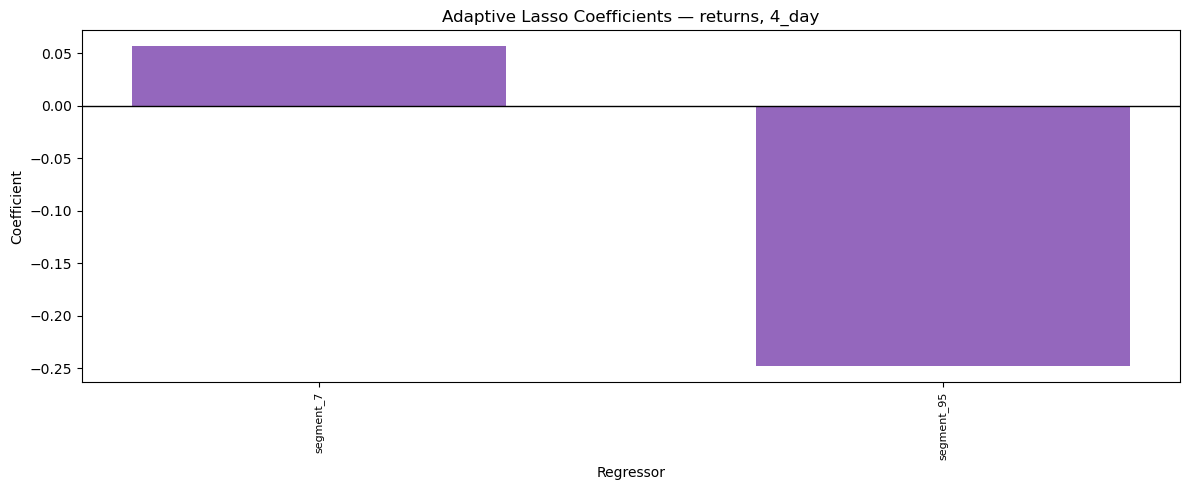

In [16]:
model.plot_adaptive_lasso()